# Chatbot

In [1]:
%matplotlib inline

### Load necessary modules

In [2]:
from os import path, getcwd
import pickle
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.autograd import Variable
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np
from tqdm import tqdm_notebook
from ipywidgets import widgets  # ipywidgets should be version 7 or higher
from IPython.display import display
from sympy import Symbol
from math import ceil
from concurrent.futures import ProcessPoolExecutor
from dataset import *
from data_utils import *
from model_utils import *
from rnn import RNN

ROOT_DIR = os.getcwd()
DATA_DIR = path.join(ROOT_DIR, 'data')
MODEL_DIR = path.join(ROOT_DIR, 'model')
EMBED_DIR = path.join(MODEL_DIR, '.vector_cache')  # pre-trained embeddings
USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    print("Using GPU")
else:
    print("Not using GPU")

Using GPU


### Download and Unpack Necessary Files, if needed
The data we use are twitter chatlogs from https://github.com/Marsan-Ma/chat_corpus

In [3]:
download('github.com/Marsan-Ma/chat_corpus/raw/master/twitter_en.txt.gz',
         ['twitter_en.txt.gz', 'twitter_en.txt'], DATA_DIR)
download('github.com/Marsan-Ma/chat_corpus/raw/master/twitter_en_big.txt.gz.partaa',
         ['twitter_en_big.txt.gz.partaa', 'twitter_en_big.txt.gz', 'twitter_en_big.txt'],
         DATA_DIR)
download('github.com/Marsan-Ma/chat_corpus/raw/master/twitter_en_big.txt.gz.partab',
         ['twitter_en_big.txt.gz.partab', 'twitter_en_big.txt.gz', 'twitter_en_big.txt'],
         DATA_DIR)

# concatenate twitter_en_big.txt.gz.partaa and .partab if needed
concatenate_two_gz(path.join(DATA_DIR, 'twitter_en_big.txt.gz'), '.partaa', '.partab')
!chmod +w data  # make sure we have write permission in data directory
# unzip gz files, as needed
unzip_gz('twitter_en.txt.gz', DATA_DIR)
unzip_gz('twitter_en_big.txt.gz', DATA_DIR)
# create a short sample.txt file with only a few lines
create_sample('twitter_en.txt', 'sample.txt', DATA_DIR, 1000)

No need to download twitter_en.txt.gz
No need to download twitter_en_big.txt.gz.partaa
No need to download twitter_en_big.txt.gz.partab
Concatenation not necessary.
twitter_en.txt already exists, decompression unneeded.
twitter_en_big.txt already exists, decompression unneeded.
sample.txt created.


## Load and build dataset
Create Dataset and Split to Train, Validation, and Test

In [4]:
# Uncomment one of the following three lines to select data file
#FILE_NAME = 'sample.txt'  # short text file for dev (1000 lines)
FILE_NAME = 'twitter_en.txt'  # medium length text file (over 50MB)
#FILE_NAME = 'twitter_en_big.txt'  # full text file (over 300MB)

load_data = False  # choose whether to load data
save_data = False  # choose whether to save data

FILE_PATH = path.join(DATA_DIR, FILE_NAME)
CHAT_DATA_NAME = 'chat_data_' + FILE_NAME[:-4] + '.p'
CHAT_DATA_PATH = path.join(DATA_DIR, CHAT_DATA_NAME)
EMBED_DIM = 200  # dimension of embedding vectors

if load_data:
    with open(CHAT_DATA_PATH, 'rb') as f:
        dataset = pickle.load(f)
else:
    #glove = vocab.GloVe('twitter.27B', dim=EMBED_DIM, cache=EMBED_DIR)
    dataset = ChatDataset(data_path = FILE_PATH,  # path to data tile
                          max_length = 25,  # maximum length of sentence
                          max_vocab_size = 8000,  # maximum size of vocabulary
                          min_freq = 5,  # minimum frequency to add word to vocabulary
                          sos_token = '<sos>',  # token that tells decoder to start response
                          eos_token = '<eos>',  # end of sentence token
                          pad_token = '<pad>',  # padding to keep sentence lengths equal
                          unk_token = '<unk>',  # unknown word (word not in vocabulary)
                          special_tokens = [],  # any other tokens to add to vocabulary
                          embed_dim = EMBED_DIM)  # dimension of embedding vectors
                          #pre_trained = glove)  # pre_trained word embeddings

    if save_data:
        with open(CHAT_DATA_PATH, 'wb') as f:
            pickle.dump(dataset, f)

print("Number of words in vocabulary: %d" % dataset.nwords)
print("Number of sentences in data: %d\n" % len(dataset))

# Split to 60% training, 20% validation, and 20% test set
train_sampler, valid_sampler, test_sampler = split_data(dataset, 0.6, 0.2, 0.2)

print("Training set size: %d" % len(train_sampler))
print("Validation set size: %d" % len(valid_sampler))
print("Test set size: %d" % len(test_sampler))

HBox(children=(IntProgress(value=0, description='Processing', max=377265), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Converting', max=315913), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Converting', max=315913), HTML(value='')))


Number of words in vocabulary: 8004
Number of sentences in data: 315913

Training set size: 189548
Validation set size: 63183
Test set size: 63182


## Sequence to Sequence Model

In [5]:
class EncoderRNN(RNN):

    def __init__(self, input_size, hidden_size, nlayers, embed_dim,
                 rnn_type, pad_idx, bidirect=True):
        super().__init__(input_size, hidden_size, nlayers, embed_dim,
                         rnn_type, pad_idx, True)  # encoder uses bidrectional RNN
        self.init_weights()  # initialize weights when initializing rnn
        #self.embedding.weight.data = dataset.vocab.vectors

    def forward(self, input, hidden, lengths=None, max_len=None):
        batch_size = input.size()[0]
        embedded = self.embedding(input)
        if lengths is not None:  # run all time step at once (evalution mode)
            output = pack_padded_sequence(embedded, lengths, batch_first=True)
            output, hidden = self.rnn(output, hidden)
            # unpack packed sequence for use in decoder with attention
            output, out_lens = pad_packed_sequence(output, batch_first=True)
            # refill padding
            n_pad = max_len - max(out_lens)
            if n_pad > 0:
                padding = Variable(torch.zeros(batch_size, n_pad, self.hidden_size))
                padding = padding.cuda() if self.is_cuda() else padding
                output = torch.cat((output, padding), 1)
        else:  # running one time step at a time (training mode)
            embedded = embedded.unsqueeze(1)
            output, hidden = self.rnn(embedded, hidden)
        return output, hidden


class DecoderRNN(RNN):

    def __init__(self, input_size, hidden_size, nlayers, embed_dim,
                 rnn_type, pad_idx, bidirect=False):
        super().__init__(input_size, hidden_size, nlayers, embed_dim,
                         rnn_type, pad_idx, False)  # decoder is not bidirectional
        self.relu = nn.LeakyReLU()
        self.linear = nn.Linear(hidden_size, input_size)
        self.softmax = nn.LogSoftmax()
        self.init_weights()
        #self.embedding.weight.data = dataset.vocab.vectors

    def init_weights(self):
        super().init_weights()
        self.linear.weight.data.uniform_(-0.1, 0.1)

    def forward(self, input, hidden):
        batch_size = input.size()[0]
        embedded = self.embedding(input).unsqueeze(1)
        output = self.relu(embedded)
        output, hidden = self.rnn(output, hidden)
        output = self.linear(output[:, 0, :])
        output = self.softmax(output)
        return output, hidden

In [6]:
class AttDecoder(RNN):
    """
    Decoder with attention
    """

    def __init__(self, input_size, hidden_size, nlayers, embed_dim,
                 rnn_type, pad_idx, bidirect=False):
        if nlayers != 2:
            raise ValueError("AttentionDecoderRNN supports 2 layers.")
        super().__init__(input_size, hidden_size, nlayers, embed_dim,
                         rnn_type, pad_idx, False)
        # learned linear mapping: previous hidden > context vector
        self.prevhid2context = nn.Linear(hidden_size, hidden_size)
        # learned linear mapping: encoder outputs > context vector
        self.encoder2context = nn.Linear(hidden_size, hidden_size)

        self.v = Parameter(torch.zeros(hidden_size, 1))
        self.tanh = nn.Tanh()
        self.out = nn.Linear(hidden_size, input_size)
        self.softmax = nn.LogSoftmax()
        self.init_weights()

    def init_weights(self):
        super().init_weights()
        init_range = 0.1
        self.prevhid2context.weight.data.uniform_(-init_range, init_range)
        self.encoder2context.weight.data.uniform_(-init_range, init_range)
        self.out.weight.data.uniform_(-init_range, init_range)
        self.v.data.uniform_(-init_range, init_range)

    def forward(self, input, prev_hidden, encoder_out):
        batch_size = input.size()[0]
        embedded = self.embedding(input).unsqueeze(1)
        # set prev_hidden to highest previous hidden layer
        if isinstance(prev_hidden, tuple):  # encoder was LSTM
            prev_hidden[0].data = prev_hidden[0][-1].data
            align1 = self.prevhid2context(prev_hidden[0]).unsqueeze(1)
        else:  # encoder was GRU
            prev_hidden = prev_hidden[-1]
            align1 = self.prevhid2context(prev_hidden).unsqueeze(1)

        align2 = self.encoder2context(encoder_out)
        score_fn = torch.matmul(self.tanh(align1 + align2), self.v)
        # scores of how much each encoder ouput should be seen
        scores = self.softmax(score_fn)
        # weighted sum of scores and encoder output over sentence indexes
        context_vector = (scores * encoder_out).sum(1)

        if isinstance(prev_hidden, tuple):
            context = torch.stack((context_vector, prev_hidden[0]))
            prev_hidden[0].data = context.data
        else:
            context = torch.stack((context_vector, prev_hidden))
            prev_hidden = context
        output, hidden = self.rnn(embedded, prev_hidden)
        output = self.softmax(self.out(output[:, 0, :]))
        return output, hidden

## Train Sequence to Sequence Model
First, we initialize the necessary components of the model, including the encoder, decoder, optimizer and learning rate scheduler of optimizer.

In [8]:
NHIDDEN = 256  # hidden layer size
NLAYERS = 2  # number of recurrent layers
EMBED_DIM = dataset.embed_dim  # dimension of embedding vectors
LEARNING_RATE = 0.001  # initial learning rate

encoder = EncoderRNN(dataset.nwords, NHIDDEN, NLAYERS, EMBED_DIM, 'GRU', dataset.pad_idx)
decoder = AttDecoder(dataset.nwords, NHIDDEN, NLAYERS, EMBED_DIM, 'GRU', dataset.pad_idx)
params = list(encoder.parameters()) + list(decoder.parameters())

w = torch.ones(dataset.nwords)
# Losses from unk token or eos token contribute less relatively to other tokens
w[dataset.unk_idx], w[dataset.eos_idx] = 0.01, 0.1
loss = nn.NLLLoss(ignore_index=dataset.pad_idx, size_average=False, weight=w)

if USE_CUDA:
    encoder.cuda()
    decoder.cuda()
    loss = loss.cuda()

# need to create optimizer after .cuda() call on models
optimizer = optim.SGD(params, lr=LEARNING_RATE)
# halve lr if validation loss is not reduced after patience*plot_every epochs
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

best_val_loss = float('inf')  # best validation loss so far
SAVE_MODEL = False  # choose whether to save best performing model on disk
ENCODER_SAVE_PATH = path.join(MODEL_DIR, 'encoder.pth')
DECODER_SAVE_PATH = path.join(MODEL_DIR, 'decoder.pth')

In order to help the model to learn, we employ teacher forcing, whereby we feed the target labels as input at each time step to the decoder. Initially, we feed the target labels frequently. However, as the model continues to train, we decrease our use of teacher forcing

In [ ]:
NEPOCH = 5000  # number of epochs
# k_val is the rate of convergence of teacher forcing probability to 0.
# initially, choose high k_val, but on subsequent runs of training cell, choose low k_val
k_val = 500

# Set teacher forcing probabilities
x_list = np.linspace(1, NEPOCH + 1, num=NEPOCH, dtype=np.int)
tf_probs = np.zeros(NEPOCH)
draws = torch.rand(NEPOCH, dataset.max_len)
choices = torch.ByteTensor(NEPOCH, dataset.max_len)

with ProcessPoolExecutor() as executer:
    for i in range(NEPOCH):
        tf_probs[i] = inv_sigm_eval(x_list[i], k_val)
        choices[i] = torch.le(draws[i], tf_probs[i])

if USE_CUDA:
    choices = choices.cuda()

plot(x_list, tf_probs, 'epoch', 'teacher forcing probability')

Run the following cell to train sequence to sequence model.
Interrupt Kernal at any time to stop training before completion.
Run cell again to resume training.

This is the first run of this cell, starting training procedure.


HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

Epoch: 500  Training loss: 1930.5954, Validation loss 38364.2293
Epoch: 1000  Training loss: 1917.0704, Validation loss 37519.7739
Epoch: 1500  Training loss: 1881.2692, Validation loss 37019.9204
Epoch: 2000  Training loss: 1823.0125, Validation loss 36309.3344
Epoch: 2500  Training loss: 1805.6941, Validation loss 35855.2803
Epoch: 3000  Training loss: 1788.7374, Validation loss 35236.8280
Epoch: 3500  Training loss: 1752.9097, Validation loss 34853.7134
Epoch: 4000  Training loss: 1736.0473, Validation loss 34334.0000
Epoch: 4500  Training loss: 1706.6355, Validation loss 34024.3153
Epoch: 5000  Training loss: 1690.6388, Validation loss 33599.8567



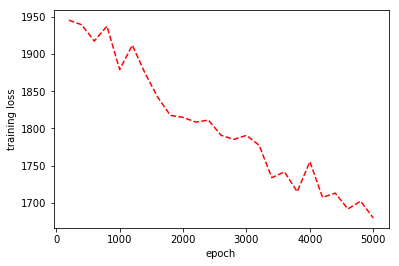

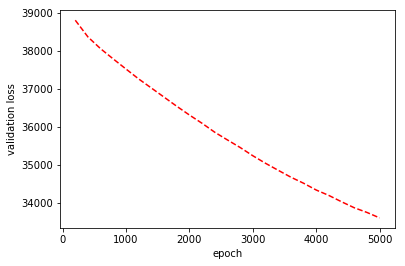

In [9]:
TRAIN_BATCH = 20  # batch size for training
# volatile flag allows greater validation set batch size
if (len(valid_sampler) // (TRAIN_BATCH * 20)) >= 1:
    VALID_BATCH = TRAIN_BATCH * 20
else:
    VALID_BATCH = TRAIN_BATCH

valid_batches = DataLoader(dataset, batch_size=VALID_BATCH,
                           sampler=valid_sampler, num_workers=0,
                           collate_fn=collate_fn, pin_memory=True,
                           drop_last=True)

# Setting up information to print and plot
plot_every = 200  # plot one data point per plot_every training losses
print_every = 500  # frequency of printing loss information
train_loss_plot, train_loss_print = 0, 0
train_losses, valid_losses, epoch_list = [], [], []


try:
    encoder.load_state_dict(best_encoder)
    decoder.load_state_dict(best_decoder)
    print("Loaded up weights from previous training.")
except NameError:
    print("This is the first run of this cell, starting training procedure.")

try:
    for epoch in tqdm_notebook(range(1, NEPOCH + 1), unit=' epochs'):
        train_loss = train(encoder, decoder, TRAIN_BATCH, train_sampler,
                           optimizer, params, dataset, choices[epoch-1], loss)
        train_loss_plot += train_loss
        train_loss_print += train_loss

        if epoch % plot_every == 0:
            # Calculate validation loss
            val_loss = evaluate(encoder, decoder, VALID_BATCH,
                                valid_batches, dataset, loss)
            scheduler.step(val_loss)  # update learning rate scheduler
            # Update losses to plot
            train_avg = train_loss_plot / plot_every
            train_losses.append(train_avg)
            valid_losses.append(val_loss)
            epoch_list.append(epoch)
            train_loss_plot = 0

            # Copy model if validation loss is the best so far
            if best_val_loss > val_loss and epoch > (NEPOCH // 2):
                best_bal_loss = val_loss
                best_encoder = encoder.state_dict()
                best_decoder = decoder.state_dict()

        if epoch % print_every == 0:
            train_avg = train_loss_print / print_every
            print('Epoch: %d  Training loss: %.4f, Validation loss %.4f'
                  % (epoch, train_avg, valid_losses[-1]))
            train_loss_print = 0

except KeyboardInterrupt:
    print("Training stopped. Run cell again to continue training.")

if len(epoch_list) > 5:
    plot(epoch_list, train_losses, 'epoch', 'training loss')
    plot(epoch_list, valid_losses, 'epoch', 'validation loss')

if SAVE_MODEL:
    torch.save(best_encoder, ENCODER_SAVE_PATH)
    torch.save(best_decoder, DECODER_SAVE_PATH)

# Chat with Model

In [10]:
encoder = EncoderRNN(dataset.nwords, NHIDDEN, NLAYERS, EMBED_DIM, 'GRU', dataset.pad_idx)
decoder = AttDecoder(dataset.nwords, NHIDDEN, NLAYERS, EMBED_DIM, 'GRU', dataset.pad_idx)
# Load best model so far
try:
    encoder.load_state_dict(best_encoder)
    decoder.load_state_dict(best_decoder)
except NameError:  # training cell was not run previously
    try:
        encoder.load_state_dict(torch.load(ENCODER_SAVE_PATH))
        decoder.load_state_dict(torch.load(DECODER_SAVE_PATH))
    except FileNotFoundError:
        print("No model found. Recommend running the training segment.")

In [11]:
text = widgets.Text()
display(text)


def chat(sender):
    try:
        output = respond(encoder, decoder, text.value, dataset)
        if len(output) == 0:
            output = "Sorry, I didn't get you. Let's about something else."
    except UserInputTooLongError:
        output = "Calm down, please talk a bit slower."
    print("You: %s" % text.value)
    print("Bot: %s" % output)

text.on_submit(chat)

Text(value='')